### **Extracting Dataset**

In [1]:
### Unzipping data

!unzip /content/drive/MyDrive/Fiverr/emotion-recognition/ravdess.zip

Archive:  /content/drive/MyDrive/Fiverr/emotion-recognition/ravdess.zip
   creating: ravdess/
   creating: ravdess/Actor_01/
  inflating: ravdess/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-02-01-01.wav  
  inflating: ravdess

### **Importing Libraries**

In [2]:
# for manipulating directories
import os
import sys

# for dataframes and numeric computation
import pandas as pd
import numpy as np

# for audio, extracting features and displaying them
import librosa
import librosa.display
from IPython.display import Audio

# for graphics
import seaborn as sns
import matplotlib.pyplot as plt

# for pre-processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# deep learning
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

# for ignoring unwanted warnings
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### **Pre-Processing**

In [3]:
# Dataset Path
Ravdess = "/content/ravdess/"

##  <center> 1. Ravdess Dataframe <center>
About: https://zenodo.org/record/1188976#.YWGTjdpByUk


Filename identifiers:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename Example: 02-01-06-01-02-01-12.mp4

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

- #### Files to Dataframe

In [4]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # For each of 24 actors
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        # For every file in each actor
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
data_path = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
data_path.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
data_path.head()

Emotions                                               Path
0   disgust  /content/ravdess/Actor_20/03-01-07-02-02-02-20...
1  surprise  /content/ravdess/Actor_20/03-01-08-01-02-01-20...
2      calm  /content/ravdess/Actor_20/03-01-02-02-02-01-20...
3  surprise  /content/ravdess/Actor_20/03-01-08-02-02-01-20...
4   neutral  /content/ravdess/Actor_20/03-01-01-01-01-01-20...

### **EDA**

First let's plot the count of each emotions in our dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


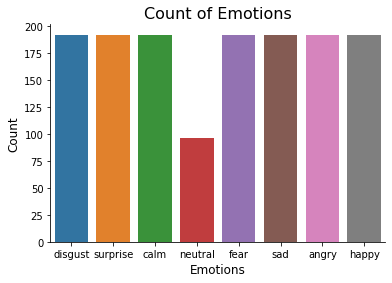

In [5]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

- #### **Waveplot & Spectrogram**

First let's plot the count of each emotions in our dataset.

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [6]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

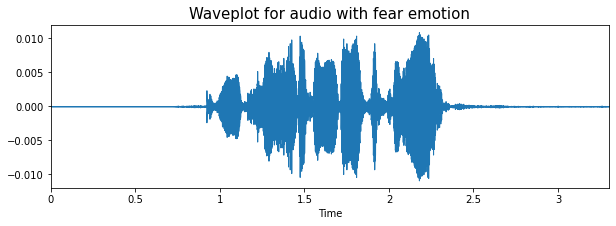

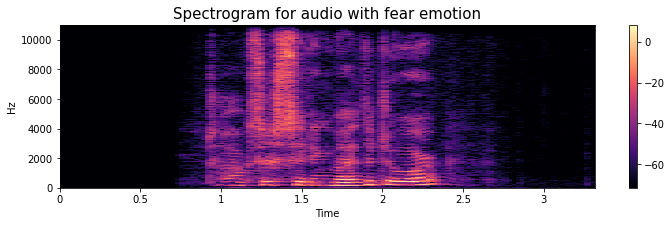

In [7]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

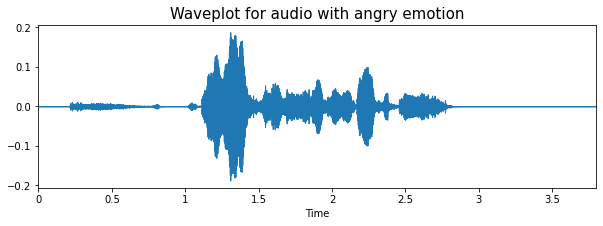

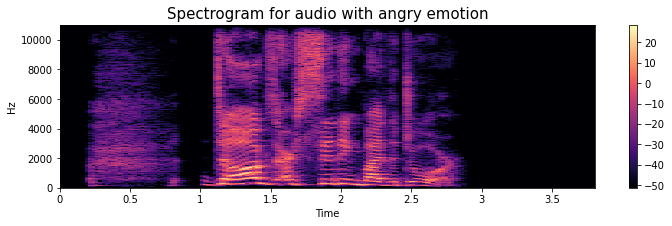

In [8]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

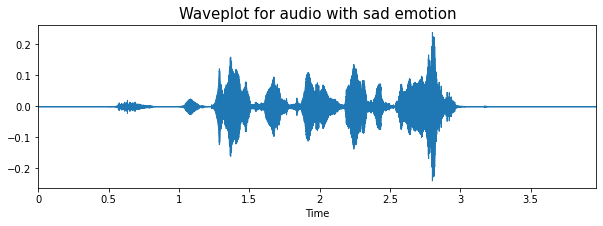

In [9]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

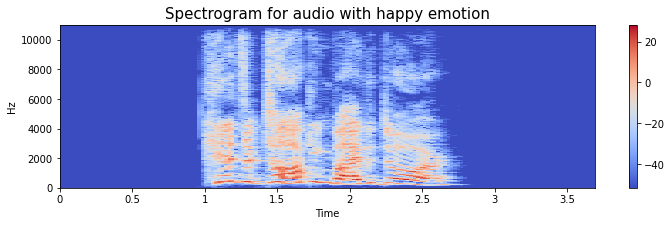

In [10]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

### **Data Augmentation**

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

- #### 1. Simple Audio

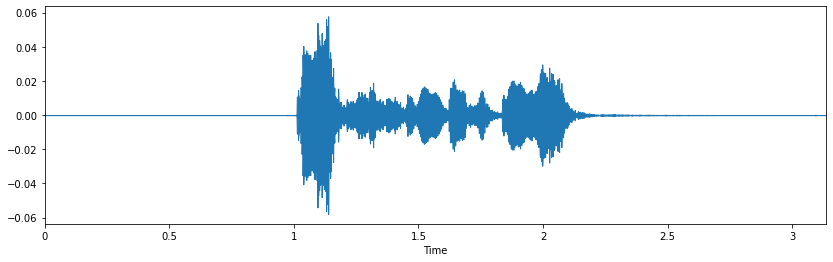

In [12]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

- #### 2. Noise Injection

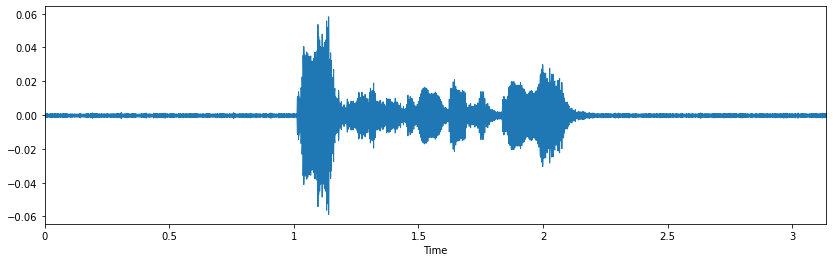

In [13]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

- #### 3. Stretching

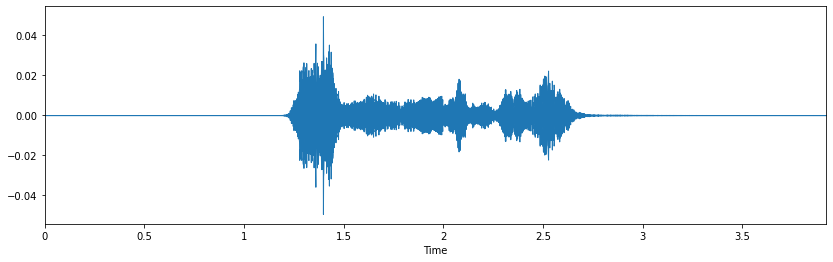

In [14]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- #### 4. Shifting

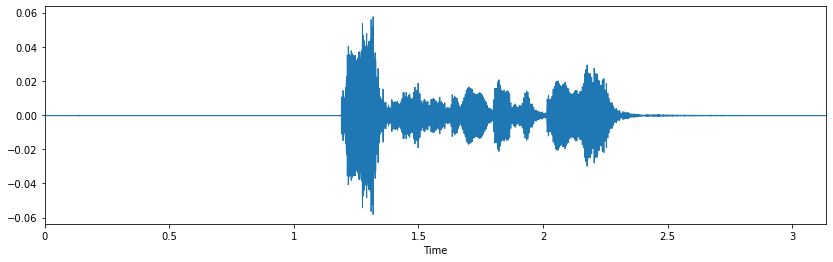

In [15]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- #### 5. Pitch

In [16]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- We will use noise, stretching(ie. changing speed) and some pitching.

### **Feature Extraction**
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.

The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

i am extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [17]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [18]:
# X, Y = [], []
# for path, emotion in zip(data_path.Path, data_path.Emotions):
#     feature = get_features(path)
#     for ele in feature:
#         X.append(ele)
#         Y.append(emotion)

In [19]:
# len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [20]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.204816  0.520950  0.510371  0.474011  0.532892  0.579986  0.632509   
1  0.282552  0.590370  0.585223  0.592380  0.648813  0.690720  0.693793   
2  0.215256  0.491286  0.512006  0.481254  0.449112  0.511350  0.573202   
3  0.307405  0.607519  0.603367  0.615059  0.629228  0.632996  0.624992   
4  0.344175  0.721769  0.740681  0.739652  0.765710  0.791622  0.747394   

          7         8         9  ...       153       154       155       156  \
0  0.589275  0.566542  0.532916  ...  0.001142  0.001574  0.001955  0.001811   
1  0.623174  0.615622  0.589010  ...  0.001363  0.001756  0.002199  0.002063   
2  0.648336  0.577750  0.561376  ...  0.000278  0.000226  0.000269  0.000454   
3  0.621670  0.656604  0.673398  ...  0.000082  0.000076  0.000076  0.000046   
4  0.691002  0.735428  0.746573  ...  0.000095  0.000091  0.000090  0.000059   

        157       158       159       160       161    labels  
0  0.001605  0.002063  0.001686  0.000616  0.000044   disgust  
1  0.001831  0.002270  0.001885  0.000843  0.000269   disgust  
2  0.000503  0.000359  0.000197  0.000089  0.000007   disgust  
3  0.000041  0.000054  0.000055  0.000016  0.000001  surprise  
4  0.000057  0.000069  0.000072  0.000031  0.000017  surprise  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

### **Load Features** 

In [21]:
Features = pd.read_csv('features.csv')
Features.head()

0         1         2         3         4         5         6  \
0  0.204816  0.520950  0.510371  0.474011  0.532892  0.579986  0.632509   
1  0.282552  0.590370  0.585223  0.592380  0.648813  0.690720  0.693793   
2  0.215256  0.491286  0.512006  0.481254  0.449112  0.511350  0.573202   
3  0.307405  0.607519  0.603367  0.615059  0.629228  0.632996  0.624992   
4  0.344175  0.721769  0.740681  0.739652  0.765710  0.791622  0.747394   

          7         8         9  ...       153       154       155       156  \
0  0.589275  0.566542  0.532916  ...  0.001142  0.001574  0.001955  0.001811   
1  0.623174  0.615622  0.589010  ...  0.001363  0.001756  0.002199  0.002063   
2  0.648336  0.577750  0.561376  ...  0.000278  0.000226  0.000269  0.000454   
3  0.621670  0.656604  0.673398  ...  0.000082  0.000076  0.000076  0.000046   
4  0.691002  0.735428  0.746573  ...  0.000095  0.000091  0.000090  0.000059   

        157       158       159       160       161    labels  
0  0.001605  0.002063  0.001686  0.000616  0.000044   disgust  
1  0.001831  0.002270  0.001885  0.000843  0.000269   disgust  
2  0.000503  0.000359  0.000197  0.000089  0.000007   disgust  
3  0.000041  0.000054  0.000055  0.000016  0.000001  surprise  
4  0.000057  0.000069  0.000072  0.000031  0.000017  surprise  

[5 rows x 163 columns]

### **Data Preparation**

- #### **Separating Features & Target Class**

In [22]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

- #### **One Hot Encoding**

In [23]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

- #### **Data Split**

In [46]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=16, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

- #### **Standardization**

In [47]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

- #### **Tensor Conversion**

In [48]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

### **Deep Learning Model**

- #### **Model Architecture**

In [49]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 81, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 41, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 21, 128)         

- #### **Training**

In [50]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
26/26 [==============================] - 1s 27ms/step - loss: 1.9877 - accuracy: 0.1954 - val_loss: 1.9138 - val_accuracy: 0.2463 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 0s 17ms/step - loss: 1.9226 - accuracy: 0.2327 - val_loss: 1.8360 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 0s 17ms/step - loss: 1.8341 - accuracy: 0.2765 - val_loss: 1.7635 - val_accuracy: 0.3111 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 0s 16ms/step - loss: 1.7856 - accuracy: 0.3006 - val_loss: 1.7038 - val_accuracy: 0.3704 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 0s 16ms/step - loss: 1.7375 - accuracy: 0.3238 - val_loss: 1.6903 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 0s 16ms/step - loss: 1.7090 - accuracy: 0.3284 - val_loss: 1.6147 - val_accuracy: 0.4222 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 0s 17ms/step - lo

- #### **Loss & Accuracy Plot**

34/34 [==============================] - 0s 4ms/step - loss: 1.4916 - accuracy: 0.6852
Accuracy of our model on test data :  68.5185194015503 %


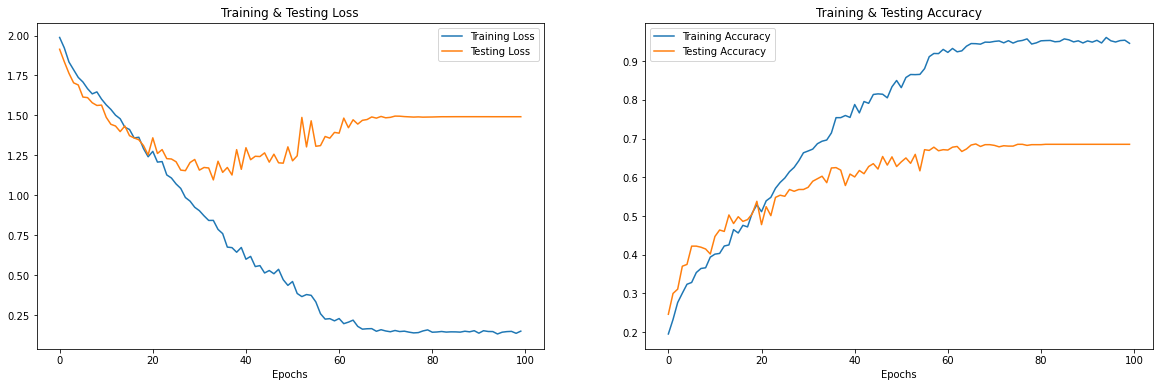

In [51]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

- #### **Prediction**

In [52]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [53]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            happy          fear
1            happy         happy
2            happy         happy
3         surprise      surprise
4          disgust       disgust
5            happy         angry
6         surprise      surprise
7            happy         happy
8            happy         happy
9             calm          calm

- #### **Evaluation**

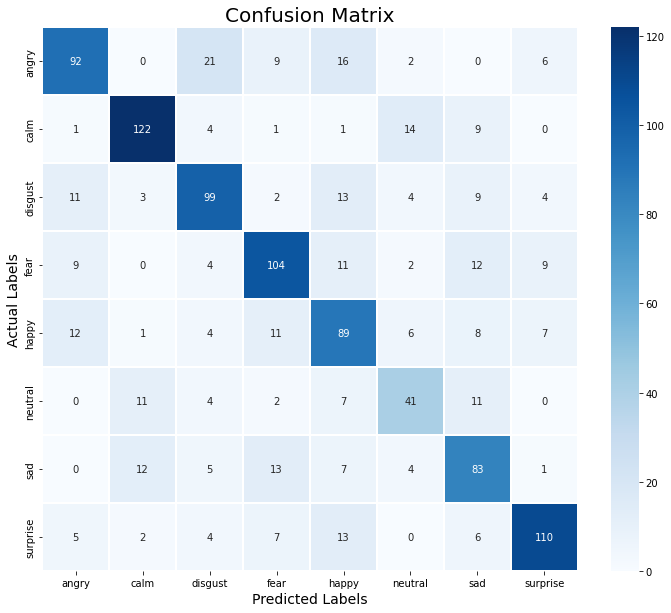

In [54]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.71      0.63      0.67       146
        calm       0.81      0.80      0.81       152
     disgust       0.68      0.68      0.68       145
        fear       0.70      0.69      0.69       151
       happy       0.57      0.64      0.60       138
     neutral       0.56      0.54      0.55        76
         sad       0.60      0.66      0.63       125
    surprise       0.80      0.75      0.77       147

    accuracy                           0.69      1080
   macro avg       0.68      0.68      0.68      1080
weighted avg       0.69      0.69      0.69      1080



- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..